This notebook has the following changes compared to "Create_wav_files_for_tones_with_changes_0.nb"

1. Training order is such that we start with simple tones and then intersperse difficult with simple. 
2. Sample many trials, throw out repetitions and finally keep about 30 trials.
3. p_back = 0.3
4. End with easy trials.(this might not be necessary)
5. For testing, start off with easy trials.
6. Predetermine order with 50 unique trials and repeat trials from extremes 2-3 times with the first 50 iterations. Don't repeat other trials. This will possibly help balance out the fact that we rarely see these extreme trials.
7. Check distribution of possible tones in the regions both simple and difficult.

In [1]:
import math
import wave
import struct
import pdb
import numpy as np
import matplotlib.pyplot as plt
import csv
import scipy.stats
import random

In [2]:
"""
Variable audio will contain a long list of samples (i.e. floating point numbers describing the
waveform).  If you were working with a very long sound you'd want to stream this to
disk instead of buffering it all in memory list this.  But most sounds will fit in 
memory.   
"""

def append_silence(audio, sample_rate, duration_milliseconds=250):
    """
    Adding silence is easy - we add zeros to the end of our array
    """
    num_samples = duration_milliseconds * (sample_rate / 1000.0)

    for x in range(int(num_samples)): 
        audio.append(0.0)
    return audio

def append_sinewave(audio, sample_rate, 
                    freq, 
                    duration_milliseconds=400, 
                    volume=1.0):
    """
    The sine wave generated here is the standard beep.  If you want something
    more aggresive you could try a square or saw tooth waveform.   Though there
    are some rather complicated issues with making high quality square and
    sawtooth waves... which we won't address here
    """ 
    num_samples = duration_milliseconds * (sample_rate / 1000.0)
    signal = []
    
    for x in range(int(num_samples)):
        signal.append(volume * math.sin(2 * math.pi * freq * (x/sample_rate)))
    audio = envelopeKCW(signal, 20, sample_rate)
    return audio

def envelopeKCW(signal,rampDur,sample_rate):
    """
    This function tries to remove the transients in the signal by enveloping the first and last period.
    Ramp duration is defined by rampDur in **ms** envelope(signal,rampDuration,samplerate)
    """
    samples = int(np.round((rampDur/1000)*sample_rate))
    x = np.arange(-np.pi,0,np.pi/samples)
    y = np.arange(0,np.pi,np.pi/samples)

    # Prepare the envelope functions
    envelope_function = np.cos(x)/2+0.5;
    
    # Fade in
    for i in range(samples):
        signal[i] = signal[i] * envelope_function[i];

    # Fade out
    for i in range(samples-1):
        current_position = len(signal) - i - 1;
        signal[current_position] = signal[current_position] * envelope_function[i+1];
    return signal


def save_wav(audio, sample_rate, file_name):
    # Open up a wav file
    wav_file=wave.open(file_name,"w")

    # wav params
    nchannels = 1
    sampwidth = 2

    # 44100 is the industry standard sample rate - CD quality.  If you need to
    # save on file size you can adjust it downwards. The standard for low quality
    # is 8000 or 8kHz.
    nframes = len(audio)
    comptype = "NONE"
    compname = "not compressed"
    wav_file.setparams((nchannels, sampwidth, sample_rate, nframes, comptype, compname))

    # WAV files here are using short, 16 bit, signed integers for the 
    # sample size.  So we multiply the floating point data we have by 32767, the
    # maximum value for a short integer.  NOTE: It is theortically possible to
    # use the floating point -1.0 to 1.0 data directly in a WAV file but not
    # obvious how to do that using the wave module in python.
    for sample in audio:
        wav_file.writeframes(struct.pack('h', int( sample * 32767.0 )))
        
    wav_file.close()
    return

def generate_tone_cloud(freq_list):
    audio = []
    sample_rate = 44100.0   
    
    freq_0 = freq_list[0];
    audio = append_sinewave(audio = audio, sample_rate = sample_rate, freq = freq_0)
    audio = append_silence(audio = audio, sample_rate = sample_rate)
    return audio, sample_rate

In [3]:
def train_task(n_trials = 10, n_tones = 3, p_low = 0.5, p_back = 0.3):
    freq_seq = np.arange(100,2000,1) #array of possible true tones
    log_freq_seq_array = np.arange(np.log10(freq_seq[0]), np.log10(freq_seq[-1]), np.log10(1003/1000)*20)
    log_freq_seq_mid = np.median(log_freq_seq_array)
    log_freq_low = [log_freq_seq_mid - 0.2,0.1]  #low freq condition is gaussian 
    log_freq_high = [log_freq_seq_mid + 0.2,0.1] #high freq condition is gaussian
    trial_tones = []
    dist_chosen = []
    kind_of_tones = []

    sample_x = np.linspace(log_freq_seq_array[0], log_freq_seq_array[-1], 101);

    lowDistWeights = scipy.stats.norm.pdf(loc = log_freq_low[0], scale = log_freq_low[1], x = sample_x);
    lowDistWeights = lowDistWeights/sum(lowDistWeights);
    highDistWeights = scipy.stats.norm.pdf(loc = log_freq_high[0], scale = log_freq_high[1], x = sample_x);
    highDistWeights = highDistWeights/sum(highDistWeights);

    bgDistWeights = scipy.stats.uniform.pdf(loc = freq_seq[0], scale = freq_seq[-1], x = 10**sample_x);
    bgDistWeights = bgDistWeights/sum(bgDistWeights);

    plt.figure()
    plt.plot(sample_x,lowDistWeights) 
    plt.plot(sample_x,highDistWeights)
    plt.plot(sample_x,bgDistWeights)
    plt.show()
    
    for trial in range(n_trials):
        signal_rand = np.random.random()
        low_dist = signal_rand < p_low #choosing true tone from either low or high condition
        tones = []
        tone_kind = []
        for n_tone in range(n_tones):
            signal_back = np.random.random()
            background = signal_back < p_back #choosing background or true tone
            if background:
                #background freq is chosen from the extremes of a uniform distribution
                if np.random.random() < 0.5:
                    nearest_log_tone = np.random.choice(log_freq_seq_array[0:8])
                else:
                    nearest_log_tone = np.random.choice(log_freq_seq_array[-8:-1])
                tone_kind.append(0)    
            else: 
                if low_dist:
                    tone = min(max(np.random.randn()*log_freq_low[1] + log_freq_low[0],\
                                   log_freq_low[0]-log_freq_low[1]),log_freq_low[0]+log_freq_low[1])
                    tone_kind.append(1)
                else:
                    tone = min(max(np.random.randn()*log_freq_high[1] + log_freq_high[0],\
                                   log_freq_high[0]-log_freq_high[1]),log_freq_high[0]+log_freq_high[1])
                    tone_kind.append(2)
                nearest_log_tone = log_freq_seq_array[np.argmin(np.abs(log_freq_seq_array - tone))]    
            nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - 10**nearest_log_tone))]
            tones.append(nearest_tone)
        trial_tones.append(tones)
        dist_chosen.append(low_dist)
        kind_of_tones.append(tone_kind)
    return trial_tones, dist_chosen, kind_of_tones, log_freq_low, log_freq_high


In [4]:
"""
Throwing away repetitions in training and testing trials
"""

def unique(trial_list, dist_list, tone_kind_list): 
  
    # intilize a null list 
    unique_trial_list = [] 
    unique_dist_list = []
    unique_tone_kind_list = []
      
    # traverse for all elements 
    for i_element in range(len(trial_list)): 
        # check if exists in unique_list or not 
        if trial_list[i_element] not in unique_trial_list: 
            unique_trial_list.append(trial_list[i_element]) 
            unique_dist_list.append(dist_list[i_element])
            unique_tone_kind_list.append(tone_kind_list[i_element])
    return unique_trial_list, unique_dist_list, unique_tone_kind_list       
            
"""
Finding simple and difficult trials
"""            

def find_difficult_trials(trial_list, tone_kind_list, low_dist, high_dist):
    n_tones = len(trial_list[0])
    difficult_barrier = 0
    difficult_trials = []
    simple_trials = []
    
    for i_element in range(len(trial_list)):
        if np.sum((np.asarray(trial_list[i_element]) < 10**(low_dist[0]-2*low_dist[1])) or \
        (np.asarray(trial_list[i_element]) > 10**(high_dist[0]+2*high_dist[1]))) > difficult_barrier:
            difficult_trials.append(i_element)
        elif np.sum((np.asarray(trial_list[i_element]) > 10**(low_dist[0]-low_dist[1]) and \
                    np.asarray(trial_list[i_element]) < 10**(low_dist[0]+low_dist[1])) or \
                    (np.asarray(trial_list[i_element]) > 10**(high_dist[0]-high_dist[1]) and \
                    np.asarray(trial_list[i_element]) < 10**(high_dist[0]+high_dist[1]))) == n_tones:
            if tone_kind_list[i_element] in [[1],[2]]:
                simple_trials.append(i_element)
    return difficult_trials, simple_trials

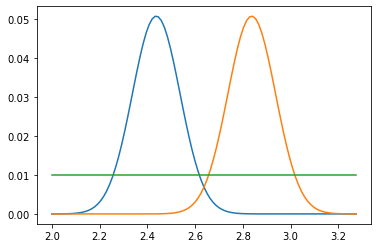

In [14]:
orig_training_trials, orig_dist_chosen, orig_tone_kind, low_dist, high_dist = \
train_task(n_trials = 300, n_tones = 1)

train_length = 30; n_tones = 1
"""
Throw away repetitions
"""
unique_trial_list, unique_dist_list, unique_tone_kind_list \
= unique(orig_training_trials, orig_dist_chosen, orig_tone_kind)

"""
Create order in which to present the training trials
"""
difficult_trials, simple_trials = find_difficult_trials(unique_trial_list, unique_tone_kind_list, \
                                                        low_dist, high_dist)
if len(difficult_trials) > 8:
    difficult_trials_keep = np.random.choice(difficult_trials,size=8,replace=False)  
else:
    difficult_trials_keep = difficult_trials
difficult_trial_idxs = np.random.choice(np.arange(10,train_length-5),size=8,replace=False)

training_trials = np.empty([train_length,n_tones])
dist_chosen = np.zeros((train_length), dtype=bool)
tone_kind = np.empty([train_length,n_tones])

training_trials[difficult_trial_idxs] = np.asarray(unique_trial_list)[difficult_trials_keep]
dist_chosen[difficult_trial_idxs] = np.asarray(unique_dist_list)[difficult_trials_keep]
tone_kind[difficult_trial_idxs] = np.asarray(unique_tone_kind_list)[difficult_trials_keep]

initial_simple_trials = np.random.choice(simple_trials,size=10,replace=False)
training_trials[:10,:] = np.asarray(unique_trial_list)[initial_simple_trials]
dist_chosen[:10] = np.asarray(unique_dist_list)[initial_simple_trials]
tone_kind[:10] = np.asarray(unique_tone_kind_list)[initial_simple_trials]

remaining_trials = np.delete(np.arange(len(unique_trial_list)),\
                             np.concatenate((difficult_trials_keep,initial_simple_trials)))

remaining_trial_idxs = np.delete(np.delete(np.arange(train_length),difficult_trial_idxs),np.arange(10))
remaining_trials_keep = np.random.choice(remaining_trials,size=12,replace=False)
training_trials[remaining_trial_idxs] = np.asarray(unique_trial_list)[remaining_trials_keep]
dist_chosen[remaining_trial_idxs] = np.asarray(unique_dist_list)[remaining_trials_keep]
tone_kind[remaining_trial_idxs] = np.asarray(unique_tone_kind_list)[remaining_trials_keep]

final_simple_trials = np.random.choice(simple_trials,size=5,replace=False)
training_trials = np.concatenate((training_trials, np.asarray(unique_trial_list)[final_simple_trials]))
dist_chosen = np.concatenate((dist_chosen, np.asarray(unique_dist_list)[final_simple_trials]))
tone_kind = np.concatenate((tone_kind, np.asarray(unique_tone_kind_list)[final_simple_trials]))

In [15]:
training_trials

array([[ 680.],
       [ 568.],
       [ 603.],
       [ 312.],
       [ 814.],
       [ 277.],
       [ 722.],
       [ 767.],
       [ 331.],
       [ 231.],
       [ 127.],
       [1671.],
       [ 246.],
       [1774.],
       [ 535.],
       [1482.],
       [1238.],
       [ 135.],
       [ 120.],
       [ 352.],
       [ 106.],
       [ 152.],
       [ 641.],
       [1396.],
       [ 143.],
       [1315.],
       [ 864.],
       [ 100.],
       [ 113.],
       [ 294.],
       [ 680.],
       [ 568.],
       [ 261.],
       [ 722.],
       [ 312.]])

In [16]:
cnt_low = 0; cnt_high = 0
rows_csv_tr = []
for i_trial in range(len(training_trials)):
    audio, sample_rate = generate_tone_cloud(training_trials[i_trial])    
    if dist_chosen[i_trial]:
        save_wav(audio, sample_rate, file_name = "soundfiles_one_tone_v0/train_wave_low_"+str(cnt_low)+".wav")
        rows_csv_tr.append(["train_wave_low_"+str(cnt_low)+".wav", 'l', training_trials[i_trial]])
        cnt_low += 1 
    else:
        save_wav(audio, sample_rate, file_name = "soundfiles_one_tone_v0/train_wave_high_"+str(cnt_high)+".wav")
        rows_csv_tr.append(["train_wave_high_"+str(cnt_high)+".wav", 'h', training_trials[i_trial]])
        cnt_high += 1 

In [17]:
# field names  
fields = ['Name', 'corrAns', 'Tones']  
    
# name of csv file  
filename = "train_one_tone_v0_files.csv"
    
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)          
    # writing the fields  
    csvwriter.writerow(fields)          
    # writing the data rows  
    csvwriter.writerows(rows_csv_tr) 

In [18]:
def test_task(n_trials = 10, n_tones = 3, p_low = 0.5, p_back = 0.3):
    freq_seq = np.arange(100,2000,1) #array of possible true tones
    log_freq_seq_array = np.arange(np.log10(freq_seq[0]), np.log10(freq_seq[-1]), np.log10(1003/1000)*20)
    log_freq_seq_mid = np.median(log_freq_seq_array)
    log_freq_low = [log_freq_seq_mid - 0.2,0.1]  #low freq condition is gaussian 
    log_freq_high = [log_freq_seq_mid + 0.2,0.1] #high freq condition is gaussian
    trial_tones = []
    dist_chosen = []
    kind_of_tones = []
    
    for trial in range(n_trials):
        signal_rand = np.random.random()
        low_dist = signal_rand < p_low #choosing true tone from either low or high condition
        tones = []
        tone_kind = []
        for n_tone in range(n_tones):
            signal_back = np.random.random()
            background = signal_back < p_back #choosing background or true tone
            if background:
                nearest_log_tone = np.random.choice(log_freq_seq_array)
                #background freq is chosen from a uniform distribution
                tone_kind.append(0)
            else: 
                if low_dist:
                    tone = min(max(np.random.randn()*log_freq_low[1] + log_freq_low[0],\
                                   log_freq_seq_array[0]),log_freq_seq_array[-1])                    
                    tone_kind.append(1)
                else:
                    tone = min(max(np.random.randn()*log_freq_high[1] + log_freq_high[0],\
                                   log_freq_seq_array[0]),log_freq_seq_array[-1])
                    tone_kind.append(2)
                nearest_log_tone = log_freq_seq_array[np.argmin(np.abs(log_freq_seq_array - tone))]
            nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - 10**nearest_log_tone))]        
            tones.append(nearest_tone)
        trial_tones.append(tones)
        dist_chosen.append(low_dist)
        kind_of_tones.append(tone_kind)
        
    return trial_tones, dist_chosen, kind_of_tones

In [19]:
orig_testing_trials, orig_test_dist, orig_test_tone_kind = test_task(n_trials = 1000, n_tones = 1)

test_length = 50; n_tones = 1

"""
Throw away repetitions
"""
unique_trial_list, unique_dist_list, unique_tone_kind_list = \
unique(orig_testing_trials, orig_test_dist, orig_test_tone_kind)

"""
Create order in which to present the testing trials
"""
difficult_trials, simple_trials = find_difficult_trials(unique_trial_list, unique_tone_kind_list,\
                                                        low_dist, high_dist)
if len(difficult_trials) > 10:
    difficult_trials_keep = np.random.choice(difficult_trials,size=10,replace=False)  
else:
    difficult_trials_keep = difficult_trials
difficult_trial_idxs = np.random.choice(np.arange(10,test_length),size=10,replace=False)
testing_trials = np.empty([test_length,n_tones])
test_dist = np.zeros((test_length), dtype=bool)
test_tone_kind = np.empty([test_length,n_tones])

testing_trials[difficult_trial_idxs] = np.asarray(unique_trial_list)[difficult_trials_keep]
test_dist[difficult_trial_idxs] = np.asarray(unique_dist_list)[difficult_trials_keep]
test_tone_kind[difficult_trial_idxs] = np.asarray(unique_tone_kind_list)[difficult_trials_keep]

initial_simple_trials = np.random.choice(simple_trials,size=10,replace=False)
testing_trials[:10,:] = np.asarray(unique_trial_list)[initial_simple_trials]
test_dist[:10] = np.asarray(unique_dist_list)[initial_simple_trials]
test_tone_kind[:10] = np.asarray(unique_tone_kind_list)[initial_simple_trials]

remaining_trials = np.delete(np.arange(len(unique_trial_list)),\
                             np.concatenate((difficult_trials_keep,initial_simple_trials)))
remaining_trial_idxs = np.delete(np.delete(np.arange(test_length),difficult_trial_idxs),np.arange(10))

remaining_trials_keep = \
np.random.choice(remaining_trials,size=test_length-(10+len(difficult_trials_keep)),replace=False)
testing_trials[remaining_trial_idxs] = np.asarray(unique_trial_list)[remaining_trials_keep]
test_dist[remaining_trial_idxs] = np.asarray(unique_dist_list)[remaining_trials_keep]
test_tone_kind[remaining_trial_idxs] = np.asarray(unique_tone_kind_list)[remaining_trials_keep]

In [20]:
testing_trials[difficult_trial_idxs], test_dist[difficult_trial_idxs], test_tone_kind[difficult_trial_idxs]

(array([[ 161.],
        [ 171.],
        [1238.],
        [1573.],
        [ 100.],
        [1166.],
        [1396.],
        [ 113.],
        [ 127.],
        [1482.]]),
 array([ True, False, False,  True,  True,  True,  True,  True,  True,
         True]),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

In [24]:
cnt_low = 0; cnt_high = 0
rows_csv_tt = []
for i_trial in range(len(testing_trials)):
    audio, sample_rate = generate_tone_cloud(testing_trials[i_trial])    
    if test_dist[i_trial]:
        save_wav(audio, sample_rate, file_name = \
                 "soundfiles_one_tone_test_v0/test_wave_low_"+str(cnt_low)+".wav")
        rows_csv_tt.append(["test_wave_low_"+str(cnt_low)+".wav",'l',testing_trials[i_trial],\
                           test_tone_kind[i_trial]])
        cnt_low += 1  
    else:
        save_wav(audio, sample_rate, file_name = \
                 "soundfiles_one_tone_test_v0/test_wave_high_"+str(cnt_high)+".wav")
        rows_csv_tt.append(["test_wave_high_"+str(cnt_high)+".wav",'h',testing_trials[i_trial],\
                           test_tone_kind[i_trial]])
        cnt_high += 1 

In [26]:
# field names  
fields = ['Name', 'corrAns', 'Tones','Tone kind']  
    
# name of csv file  
filename = "test_one_tone_v0_files.csv"
    
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)          
    # writing the fields  
    csvwriter.writerow(fields)          
    # writing the data rows  
    csvwriter.writerows(rows_csv_tt) 